In [1]:

import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym_envs, the constraint information is output as an element of the info dictionary in gym.step() function


# NOTE: This notebook is used after training the classical reach-avoid value function via DDPG


"""
    We can learn the classical reach-avoid value function by using DDPG under the classical annealed reach-avoid Bellman equation in arXiv:2112.12288:
    python run_training_ddpg.py --task ra_droneracing_Game-v6 --control-net 512 512 512 512 --disturbance-net 512 512 512 512 --critic-net 512 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160 --is-game-baseline True
"""
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='dubins-v0')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.1)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512, 512, 512, 512]) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512, 512, 512, 512]) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512, 512, 512, 512]) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=True) # True -> classical approximated reach-avoid Bellman equation, False -> our new Reach-RL Bellman equation
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    args = parser.parse_known_args()[0]
    return args



args=get_args()

env = gym.make(args.task)
# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') #and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

args.action1_shape = env.action1_space.shape or env.action1_space.n
#args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
#args.max_action2 = env.action2_space.high[0]


train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.hidden_sizes,
        activation=critic_activation,
        concat=True,
        device=args.device
    )

critic = Critic(critic_net, device=args.device).to(args.device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
if args.control_net is None:
    args.control_net = args.hidden_sizes
#if args.disturbance_net is None:
#    args.disturbance_net = args.hidden_sizes
if args.critic_net is None:
    args.critic_net = args.hidden_sizes
# import pdb; pdb.set_trace()
log_path = None

from LCRL.policy import avoid_DDPGPolicy_annealing as DDPGPolicy
print("DDPG under the Avoid annealed Bellman equation has been loaded!")

#if args.is_game_baseline:
#    from LCRL.policy import reach_avoid_game_DDPGPolicy_annealing as DDPGPolicy
#    print("DDPG under the Reach-Avoid annealed Bellman equation has been loaded!")
#else:
#    from LCRL.policy import reach_avoid_game_DDPGPolicy as DDPGPolicy
#    print("DDPG under Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = Actor(
    actor1_net, args.action1_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
#actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
#actor2 = Actor(
#    actor2_net, args.action2_shape, max_action=args.max_action1, device=args.device
#).to(args.device)
#actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)

policy = DDPGPolicy(
critic,
critic_optim,
tau=args.tau,
gamma=args.gamma,
exploration_noise=GaussianNoise(sigma=args.exploration_noise),
reward_normalization=args.rew_norm,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
#actor2=actor2,
#actor2_optim=actor2_optim,
actor_gradient_steps=args.actor_gradient_steps,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)
else:
    log_path = os.path.join(args.logdir, args.task, 'ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)


log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )
args.gamma


/home/kensuke/miniconda3/envs/lcrl/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/kensuke/miniconda3/envs/lcrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:164: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/kensuke/miniconda3/envs/lcrl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


DDPG under the Avoid annealed Bellman equation has been loaded!


0.95

In [2]:
# NOTE! if you want to use the pre-trained model, you can set the path to the model here:
# otherwise, you can skip this cell and move to the next cell
#log_path = "pretrained_neural_networks/ra_droneracing_Game-v6/baseline_ddpg_reach_avoid_actor_activation_ReLU_critic_activation_ReLU_game_gd_steps_1_tau_0.005_training_num_8_buffer_size_40000_c_net_512_4_a1_512_4_a2_512_4_gamma_0.95/noise_0.1_actor_lr_0.0001_critic_lr_0.001_batch_512_step_per_epoch_40000_kwargs_{}_seed_0"
log_path = "/home/kensuke/latent-safety/Lipschitz_Continuous_Reachability_Learning/experiment_script/log/dubins-v0/ddpg_reach_avoid_actor_activation_ReLU_critic_activation_ReLU_game_gd_steps_1_tau_0.005_training_num_8_buffer_size_40000_c_net_512_4_a1_512_4_a2_512_4_gamma_0.95"

In [3]:
# data reloading module:
epoch_id = 40
envs = gym.make(args.task)

# check if the log path exists
if os.path.exists(log_path):
    policy.load_state_dict(torch.load('/home/kensuke/latent-safety/Lipschitz_Continuous_Reachability_Learning/experiment_script/log/dubins-v0/ddpg_reach_avoid_actor_activation_ReLU_critic_activation_ReLU_game_gd_steps_1_tau_0.005_training_num_8_buffer_size_40000_c_net_512_4_a1_512_4_a2_512_4_gamma_0.95/noise_0.1_actor_lr_0.0001_critic_lr_0.001_batch_512_step_per_epoch_40000_kwargs_{}_seed_0/epoch_id_0/policy.pth'))

    #policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")


policy loaded!


/home/kensuke/miniconda3/envs/lcrl/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/tmp/ipykernel_1064850/2204933802.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for a

In [4]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [5]:
from LCRL.data import Batch
def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from tqdm import tqdm

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_1064850/1214623825.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


-0.2565838694572449 1.826326608657837


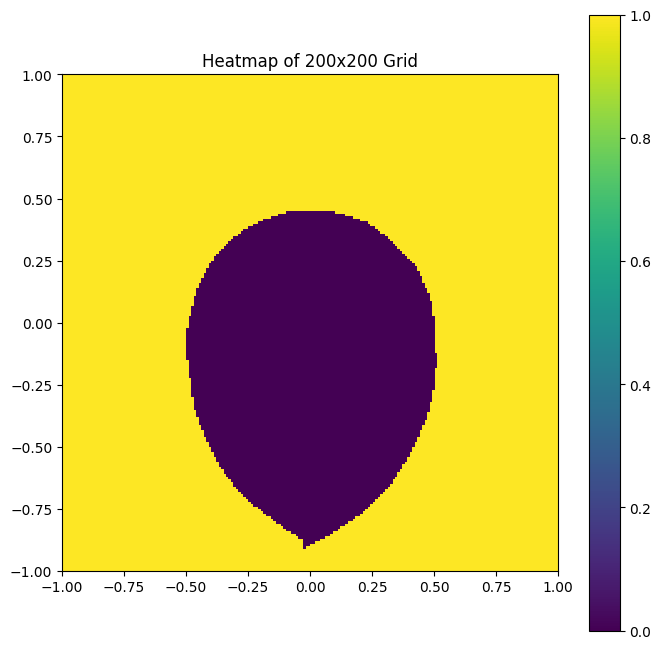

'\nsurf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,vmin= V.min(), vmax=-V.max(),\n                        linewidth=0, antialiased=False)'

In [6]:
# plt.rcParams['font.family'] = 'Times New Roman'

x = np.arange(-1.0, 1.0, 0.01)
y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))
ego_theta = np.pi/2



X_V = X
Y_V = Y
for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            X[ii,jj],
            Y[ii,jj], ego_theta,
        ])
        V[ii,jj] = evaluate_V( tmp_point )

print(V.min(), V.max())
plt.figure(figsize=(8, 8))  # Set the figure size to make it more readable
V_flipped = np.flipud(V)
plt.imshow(V_flipped>0, cmap='viridis', extent=[-1, 1, -1, 1], interpolation='nearest')

plt.colorbar()  # Add a colorbar to show the scale of values
plt.title("Heatmap of 200x200 Grid")
plt.show()
'''
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,vmin= V.min(), vmax=-V.max(),
                        linewidth=0, antialiased=False)'''

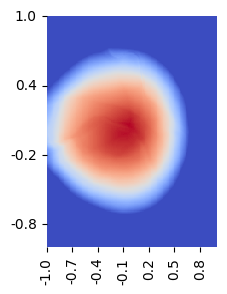

In [65]:
import seaborn as sns

x_interval = 30
y_interval = 60

fig, ax = plt.subplots(figsize=(2.2, 3))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax, vmin= V_flipped.min(), vmax=-V_flipped.min(),
            cbar=False,
            )

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+0.02, 1))

contours = ax.contour((X+0.9)*100, (Y+2.6)*100, V_flipped, levels=[0], colors="black", linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [7]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1


In [10]:
"""
success rate is computed by recording the number of initial states that can be maintained within the target set for 100 steps
"""
from LCRL.data import Batch
from tqdm import tqdm

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    act[3:] = np.random.uniform(-1, 1, size = 3)
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

n_dim = env.observation_space.shape[0]
def roll_out_traj(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    
    state_traj[:,0] = state
    env.reset(initial_state = state)
    safe_reaching_time = np.inf
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        rand_disturbance = np.random.uniform(low = -1, high = 1, size = (3,))
        action = np.array([action[0], action[1], action[2], rand_disturbance[0], rand_disturbance[1], rand_disturbance[1]])
        tmp, rew, _, _, info = env.step(action)
        
        state_traj[:,t+1] = tmp
        if rew > 0 and t<=horizon-2 and info["constraint"] > 0:
            if t>1 and verbose:
                print("success at time = {}!".format(t))
            return state_traj[:,:t+1], True, rand_disturbance

        if info["constraint"] < 0:
            print("constraint violated!") if verbose else None
            return state_traj[:,:t+1], False, rand_disturbance
            break
        
        if state_traj[2,t+1] > 0 or state_traj[8,t+1] > 0:
            print("A Drone passed frame!") if verbose else None
            return state_traj[:,:t+1], False, rand_disturbance
            break
    return state_traj, False, rand_disturbance

num_samples = 100
sampled_states = np.zeros((n_dim,num_samples))
num_success = 0
horizon = 300
high = np.array([  
                0.8,  0.2,  -1.5,  0.7,  0.8,  0.2,
                0.8,  0.2,  -1.5,  0.7,  0.8,  0.2,
                ], dtype=np.float32) # x1 vx1 y1 vy1 z1 vz1          x2 vx2 y2 vy2 z2 vz2
low  = np.array([  
                -0.8, -0.2, -3, 0.2, -0.8, -0.2,
                -0.8, -0.2, -3, 0.2, -0.8, -0.2,
                ], dtype=np.float32)

list_of_failure_states = []
list_of_success_states = []
for ii in tqdm(range(num_samples)):
    sampled_initial_state = np.random.uniform(low = low, high = high)
    tmp = envs.reset(initial_state = sampled_initial_state)
    sampled_states[:,ii] = tmp[0]
    while evaluate_V(sampled_states[:,ii]) < 0:
        sampled_initial_state = np.random.uniform(low = low, high = high)
        tmp = envs.reset(initial_state = sampled_initial_state)
        sampled_states[:,ii] = tmp[0]
    traj, success,_ = roll_out_traj(envs, sampled_states[:,ii], horizon, verbose = True)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(sampled_states[:,ii])
    else:
        list_of_failure_states.append(sampled_states[:,ii])
        continue
num_success/num_samples

 50%|█████     | 50/100 [00:00<00:00, 243.66it/s]

success at time = 9!
constraint violated!
success at time = 14!
success at time = 16!
success at time = 12!
success at time = 17!
success at time = 13!
success at time = 10!
success at time = 6!
success at time = 2!
success at time = 8!
success at time = 13!
success at time = 9!
success at time = 11!
success at time = 4!
success at time = 13!
success at time = 6!
success at time = 13!
success at time = 10!
success at time = 17!
success at time = 9!
success at time = 15!
success at time = 14!
success at time = 4!
success at time = 13!
success at time = 13!
success at time = 8!
success at time = 7!
success at time = 7!
success at time = 4!
success at time = 29!
success at time = 7!
success at time = 5!
success at time = 10!
success at time = 17!
success at time = 10!
success at time = 15!
success at time = 16!
success at time = 9!
success at time = 11!
success at time = 4!
success at time = 7!
success at time = 7!
success at time = 10!
success at time = 13!
success at time = 5!


 75%|███████▌  | 75/100 [00:00<00:00, 238.03it/s]

constraint violated!
success at time = 12!
success at time = 23!
success at time = 20!
success at time = 14!
success at time = 3!
success at time = 10!
success at time = 13!
success at time = 12!
success at time = 12!
success at time = 4!
success at time = 15!
success at time = 6!
success at time = 8!
success at time = 12!
success at time = 11!
success at time = 10!
success at time = 13!
success at time = 11!
success at time = 14!
success at time = 11!
success at time = 13!
success at time = 13!
success at time = 3!
success at time = 15!
success at time = 2!
success at time = 14!
success at time = 8!
success at time = 13!
success at time = 13!
success at time = 12!
success at time = 14!
success at time = 18!
success at time = 12!
success at time = 11!
success at time = 9!
success at time = 11!
success at time = 9!
success at time = 10!
success at time = 5!
success at time = 12!
success at time = 10!


100%|██████████| 100/100 [00:00<00:00, 241.22it/s]

success at time = 13!


0.98

In [11]:
# save the list of sampled states, we will use them in the notebook "droneracing_post_training_DDPG_evaluation_new.ipynb" to evaluate the learned policy there on this set of initial states
import pickle
with open("list_of_initial_states_droneracing_from_classical_reachability_value_function_learning.pkl", "wb") as f:
    pickle.dump(list_of_success_states, f)

In [9]:
# # Test how the learned policy performs on the sampled initial states from droneracing_post_training_DDPG_evaluation_new.ipynb
# NOTE! We assume the list_of_initial_states_droneracing_from_new_reachability_value_function_learning.pkl is stored in the current directory, which can be obtained from droneracing_post_training_DDPG_evaluation_new.ipynb
import pickle
with open("list_of_initial_states_droneracing_from_new_reachability_value_function_learning.pkl", "rb") as f:
    list_of_initial_sampled_states = pickle.load(f)
num_samples = len(list_of_initial_sampled_states)
list_of_success_states = []
list_of_failure_states = []
num_success = 0
for ii in tqdm(range(num_samples)):
    tmp = envs.reset(initial_state = sampled_initial_state)
    traj, success,_ = roll_out_traj(envs, list_of_initial_sampled_states[ii], horizon, verbose = True)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(list_of_initial_sampled_states[ii])
    else:
        list_of_failure_states.append(list_of_initial_sampled_states[ii])
        continue
num_success/num_samples

 41%|████      | 41/100 [00:00<00:00, 198.01it/s]

success at time = 2!
success at time = 28!
constraint violated!
success at time = 33!
success at time = 17!
success at time = 29!
constraint violated!
success at time = 9!
success at time = 11!
success at time = 6!
success at time = 20!
success at time = 15!
success at time = 18!
success at time = 24!
success at time = 13!
success at time = 18!
success at time = 26!
success at time = 13!
success at time = 16!
success at time = 16!
success at time = 20!
success at time = 20!
success at time = 28!
constraint violated!
constraint violated!
success at time = 21!
success at time = 15!
success at time = 9!
success at time = 25!
success at time = 16!
constraint violated!
success at time = 15!
constraint violated!
success at time = 19!
success at time = 22!
constraint violated!
success at time = 2!
success at time = 2!
success at time = 21!
success at time = 31!
success at time = 13!
success at time = 14!


 86%|████████▌ | 86/100 [00:00<00:00, 213.81it/s]

success at time = 14!
success at time = 7!
success at time = 14!
success at time = 23!
success at time = 13!
success at time = 10!
success at time = 26!
success at time = 27!
success at time = 14!
success at time = 13!
success at time = 12!
success at time = 22!
success at time = 14!
success at time = 21!
constraint violated!
success at time = 15!
constraint violated!
success at time = 26!
success at time = 24!
success at time = 13!
success at time = 19!
success at time = 14!
success at time = 19!
success at time = 17!
constraint violated!
success at time = 30!
success at time = 5!
success at time = 31!
success at time = 13!
success at time = 18!
success at time = 7!
success at time = 7!
success at time = 12!
success at time = 14!
success at time = 16!
constraint violated!
success at time = 16!
success at time = 34!
success at time = 16!
success at time = 12!
success at time = 14!
success at time = 16!
success at time = 9!
success at time = 25!


100%|██████████| 100/100 [00:00<00:00, 209.46it/s]

constraint violated!
success at time = 18!
success at time = 6!
success at time = 22!
success at time = 12!
success at time = 27!
success at time = 5!
constraint violated!
success at time = 17!
success at time = 18!
success at time = 14!
success at time = 16!


0.87

success at time = 24!


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 74.79it/s]
/tmp/ipykernel_38494/3819624115.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5,
/tmp/ipykernel_38494/3819624115.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
100%|██████████| 25/25 [00:06<00:00,  3.58it/s]


(-0.95, 0.95)

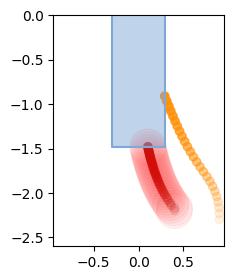

In [12]:
#9748
# note that we need to load epoch = 1600!!!!!!!!
# plot the target set too!
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
from tqdm import tqdm
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'))
initial_state = np.array([
    0.9, ego_vx, # x, vx
    -2.3, ego_vy,
    ego_z, ego_vz,
    ad_x, ad_vx,
    ad_y, ad_vy,
    ad_z, ad_vz
])
horizon = 300
traj,_,rand_disturbance = roll_out_traj(envs, initial_state, horizon, verbose=True)
fig, ax = plt.subplots(figsize=(2.2,3))
min_x = -0.6
max_x = 0.6
min_y = -2.8
max_y = -1.4
alphas = np.linspace(0.1, 1.0, len(traj[0,:]))
ax.scatter(traj[0,:], traj[2,:],  color = color_list[0], alpha = alphas ) #"o", color="#314cd4",  label = "ego")
ax.scatter(traj[6,:], traj[8,:],  color = color_list[4], alpha = alphas) #'o', color="#EA3323",label = "adversary")


def target_set(env, X, Y, tmp_point = np.array([
    0, 0.,-1, 0.8,-0.0, 0,0.3,  0,-2.2, 0.3,0., 0
])):
    reward = np.zeros((X.shape))
    for ii in tqdm(range(reward.shape[0])):
        for jj in range(reward.shape[1]):
            tmp_point[0], tmp_point[2] = X[ii,jj], Y[ii,jj]
            env.reset(initial_state = tmp_point)
            reward[ii,jj] = 1 if env.step([0,0,0,0,0,0])[1]>=0 else 0
    return reward

plt.rcParams["contour.linewidth"]=1.5

for j in tqdm(range(traj.shape[1])):    
    # plot the target set
    if j == traj.shape[1]-1:
        x = np.arange(-0.9, 0.9, 0.005)
        y = np.arange(-2.6, 0, 0.005)
        X, Y = np.meshgrid(x, y)
        reward = target_set(envs, X, Y, traj[:,j])
        plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5, 
                    label = "target set"
                    # hatches=['//']
                    )
        plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
    ax.add_patch(matplotlib.patches.Circle((traj[6,j], traj[8,j]), 0.2, color='r', fill=True, alpha=0.05))
ax.set_ylim([-2.6, 0])
ax.set_xlim([-0.95, 0.95])